In [11]:
    ###################################################################################################
    ####
    #este ejemplo esta basado en
    #https://blog.quantinsti.com/machine-learning-classification-strategy-python/?utm_source=quora&utm_medium=answer_is
    ####
    ###################################################################################################
    #Carga las librerías
    !pip install pandas_datareader
    !pip install ta
    # Machine learning classification libraries
    from sklearn.svm import SVC
    from sklearn.metrics import scorer
    from sklearn.metrics import accuracy_score
     
    # For data manipulation
    import pandas as pd
    import numpy as np
    from ta import * 
     
    # To plot
    import matplotlib.pyplot as plt
    import seaborn
     
    # To fetch data
    from pandas_datareader import data as pdr

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


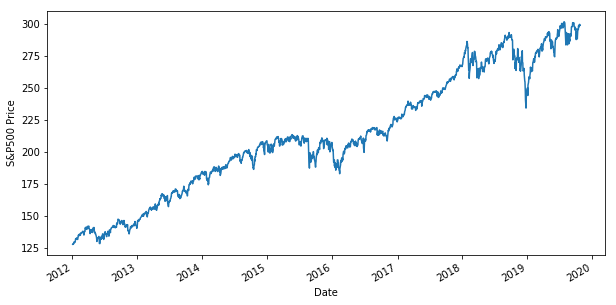

In [49]:
#importa los datos de Yahoo y los plotea

    Df = pdr.get_data_yahoo('SPY', start="2012-01-01") 
#    Df = pdr.get_data_yahoo('SPY', start="2012-01-01", end="2017-10-01") 
    
    Df= Df.dropna()
    Df.Close.plot(figsize=(10,5))
    plt.ylabel("S&P500 Price")
    plt.show()

In [50]:
#df.colums
print(Df.columns)
Df = utils.dropna(Df)
#Modificamos columnas de acciones
for item in ['Open', 'High', 'Low']:
    Df[item] = Df[item] * Df['Adj Close'] / Df['Close']
Df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low','Adj Close': 'close', 'Volume': 'volume'}, inplace=True)
Df.drop(['Close'],axis=1, inplace=True)
    
print(Df.columns)
print(Df.info())
print(Df.isna().sum())
Df=Df.dropna(inplace=True)

# Add all ta features filling nans values
Df = add_all_ta_features(Df, "open", "high", "low", "close", "volume", fillna=True)


Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')
Index(['high', 'low', 'open', 'volume', 'close'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1965 entries, 2012-01-03 to 2019-10-23
Data columns (total 5 columns):
high      1965 non-null float64
low       1965 non-null float64
open      1965 non-null float64
volume    1965 non-null float64
close     1965 non-null float64
dtypes: float64(5)
memory usage: 92.1 KB
None
high      0
low       0
open      0
volume    0
close     0
dtype: int64


TypeError: 'NoneType' object is not subscriptable

In [3]:
# Variable a estimar
Df['Return3'] = np.log(Df.Close.shift(-2) / Df.Close.shift(-1))
y = pd.DataFrame(np.where(Df['Return3']> 0,1,-1))
#y=y.shift(-1)
y=y.fillna(0)
y.tail()


,0
1960,1
1961,-1
1962,1
1963,-1
1964,-1


In [4]:
# Creaación de Features
    Df['Open-Close'] = Df.Open - Df.Close
    Df['High-Low'] = Df.High - Df.Low
     
    X=Df[['Open-Close','High-Low']]
    ''' 	Open-Close 	High-Low
Date 		
2017-09-25 	0.220001 	1.470001
2017-09-26 	0.339996 	0.889999
2017-09-27 	-0.169998 	1.620010
2017-09-28 	-0.620010 	0.809998
2017-09-29 	-0.889999 	1.190002'''
    X.tail()
    

,Open-Close,High-Low
Date,,
2019-10-17,0.399994,1.720001
2019-10-18,0.720001,2.369995
2019-10-21,-0.569977,1.269989
2019-10-22,1.569977,1.989990
2019-10-23,-0.579987,0.890015


In [10]:
#Vemos la multicolinealidad con la correlación entre las features
features=list(Df.columns[-2:])
Df[features].corr()

,Open-Close,High-Low
Open-Close,1.000000,0.169462
High-Low,0.169462,1.000000


In [ ]:
# Split la muestra entre InSample y OutSample
    split_percentage = 0.8
    split = int(split_percentage*len(Df))
     
    # Train data set
    X_train = X[:split]
    y_train = y[:split]
     
    # Test data set
    X_test = X[split:]
    y_test = y[split:]
    '''            Open-Close  High-Low
Date                            
2016-08-01    0.250000  1.239990
2016-08-02    1.099991  2.259995
2016-08-03   -0.699997  1.119995
2016-08-04   -0.100006  2.529999
2016-08-05   -1.769989  1.819992
      0
1151 -1
1152  1
1153  1
1154  1
1155 -1'''
    
    print(X_train.tail())
    print(y_train.tail())


In [ ]:
#Creamos el modelo
    cls = SVC(gamma='auto').fit(X_train.values, np.ravel(y_train))

In [ ]:
#aquí vemos el ajuste del modelo
    accuracy_train = accuracy_score(y_train, cls.predict(X_train))
     
    accuracy_test = accuracy_score(y_test, cls.predict(X_test))
    print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
    print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))

In [ ]:
#Realiamos la predicción
    Df['Predicted_Signal'] = cls.predict(X)
     
    # Calculate log returns
    Df['Return'] = np.log(Df.Close.shift(-1) / Df.Close)*100
    Df['Return1'] = Df.Close.pct_change().shift(-2)*100
    
    Df['Strategy_Return'] = Df.Return.shift(-1) * Df.Predicted_Signal
    Df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return1.iloc[split:].cumsum().plot(figsize=(10,5))
    plt.legend(loc='upper left')
    plt.ylabel("Strategy Returns (%)")
    plt.show()



In [ ]:
# Calculate log returns
    Df['Return'] = Df.Close.pct_change().shift(-2)
    Df['Strategy_Return'] = Df.Return * Df.Predicted_Signal
    Df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return.iloc[split:].cumsum().plot(figsize=(10,5))
    plt.legend(loc='upper left')
    plt.ylabel("Strategy Returns (%)")
    plt.show()


In [ ]:
#Realiamos la predicción
    Df['Predicted_Signal'] = cls.predict(X)
     
    # Calculate log returns
    Df['Return'] = np.log(Df.Close / Df.Close.shift(1))*100
    Df['Strategy_Return'] = Df.Return.shift(-2) * Df.Predicted_Signal
    Df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
    Df.Return.iloc[split:].cumsum().plot(figsize=(10,5))
    plt.legend(loc='upper left')
    plt.ylabel("Strategy Returns (%)")
    plt.show()



In [ ]:
    Df['signal']=y
    Df['Return1'] = np.log(Df.Close / Df.Close.shift(1))
    Df['Return2'] = Df.Close.pct_change().shift(-1)
    Df['Return3'] = np.log(Df.Close.shift(-1) / Df.Close)

    Df[['Return1','Return2','Return3','Predicted_Signal','signal']].tail()
